In [1]:
import implementations
import pandas as pd
import numpy as np
import helpers
import preprocessing


In [2]:
datapath_train = "./dataset/"
x_train, x_test, y_train, train_ids, test_ids = helpers.load_csv_data(datapath_train)
data_path_names = "./dataset/x_train.csv"
feature_names = np.genfromtxt(data_path_names, max_rows=2, delimiter=",", names=True).dtype.names
feature_names = feature_names[1:]  
columns = np.asarray(feature_names[0:])

In [3]:
%reload_ext autoreload
%autoreload 2
import preprocessing
import importlib
importlib.reload(preprocessing)
from preprocessing import *
from metrics import *

In [4]:
x_train_preprocess, x_test_preprocess, y_train = preprocessing.dataPreprocess(x_train, x_test, y_train, columns, feature_names)
x_train_preprocess.shape,x_test_preprocess.shape #curent size before buildpoly : 498 538 with build poly d=3

/Users/antoineschutz/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antoineschutz/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


((328135, 538), (109379, 538))

In [5]:
import cross_validation as cv
import metrics
import matplotlib.pyplot as plt

N = x_train_preprocess.shape[0]
subset_size = N //5

# print(x_new_del_train.shape)
# print(y_train.shape)

# Generate random indices to select data points for the subset
indices = np.random.choice(len(x_train), subset_size, replace=False)

# Create the random subset from x_train and y_train
x_cv = x_train_preprocess[indices]
y_cv = y_train[indices]


x_cv.shape,y_cv.shape


((65627, 538), (65627,))

In [6]:
def plot_confusion_matrix(actual_y, pred_y, title):
    tp, tn, fp, fn = metrics.calculate_parameters(pred_y, actual_y)
    # Create a confusion matrix plot
    confusion_matrix = [[tn, fp], [fn, tp]]

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()

    plt.xticks([0, 1], ["Predicted (-1)", "Predicted (1)"])
    plt.yticks([0, 1], ["Real value is (-1)", "Real value is (1)"])

    for i in range(2):
        for j in range(2):
            cell_value = confusion_matrix[i][j]
            text_color = 'white' if cell_value > 50000 else 'black'  # Adjust the threshold as needed
            plt.text(j, i, str(confusion_matrix[i][j]), ha='center', va='center', color=text_color, fontsize=16)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)

    plt.show()

In [10]:
best_gamma, best_max_iters = cv.cross_validation_linear_regression(y_cv, x_cv, sgd=False, max_iters_list=[1000], gamma_list=[0.01])

/Users/antoineschutz/Documents/GitHub/ml-project-1-ai-ron-team/implementations.py:142: RuntimeWarning: invalid value encountered in subtract
  w = w - gamma * grad


Best gamma value is 0.01
Best Threshold value is -0.5
Best max_iters value is 1000
________________________
Average F1 score: 0.00 %
Average accuracy: 91.16 %
________________________


Best threshold value is : -0.5
________________________
Average F1 score: 42.18 %
Average accuracy: 88.90 %
________________________


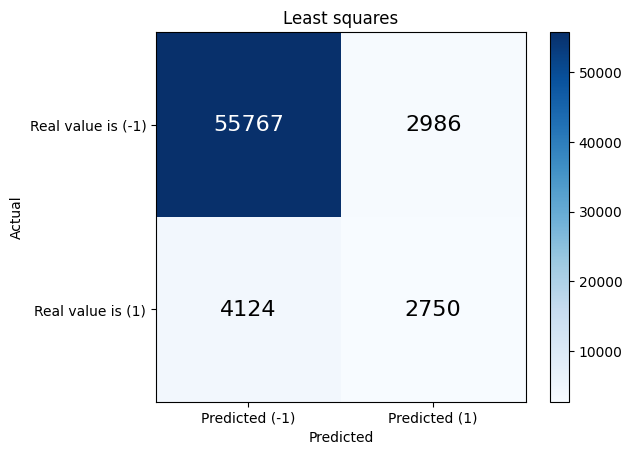

In [9]:
# Least squares
# With k=30 and subset_size=200 000, best F1 score = 11.75%
best_thresh = cv.cross_validation_least_squares(y_cv, x_cv)

w, _ = implementations.least_squares(y_cv, x_cv)
pred = x_cv.dot(w)
pred_discrete = np.where(pred >= best_thresh, 1, -1)    

plot_confusion_matrix(y_cv, pred_discrete, "Least squares")

Best lambda value is 1e-16
Best threshold value is -0.6
________________________
Average F1 score: 42.40 %
Average accuracy: 85.73 %
________________________


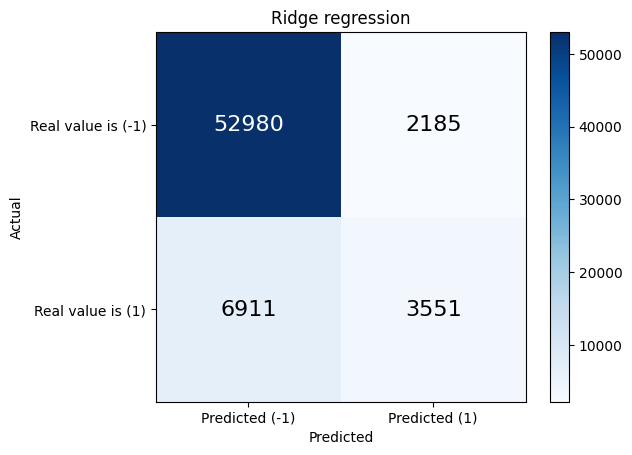

In [10]:
# Ridge regression

#lambda_values = [min_lambda + step_size * i for i in range(int((max_lambda - min_lambda) / step_size) + 1)]

best_lambda,best_thresh = cv.cross_validation_ridge_regression(y_cv, x_cv,k=5,threshold=[-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2] ,lambda_values=[1e-16,1e-15,1e-14])

w, _ = implementations.ridge_regression(y_cv, x_cv, 1e-16)
pred = x_cv.dot(w)
pred_discrete = np.where(pred >= best_thresh, 1, -1)

plot_confusion_matrix(y_cv, pred_discrete, "Ridge regression")







In [14]:


w, _ = implementations.ridge_regression(y_train, x_train_preprocess, 1e-16)
pred = x_test_preprocess.dot(w)
y_pred = np.where(pred >= -0.6, 1, -1)


helpers.create_csv_submission(test_ids, y_pred, "Submission_ridge_with_threshold.csv")